In [100]:
import pandas as pd
import numpy as np 
import time
import os
import sys
import json, csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# import catboost
# import cslib


In [3]:
# mount drive and setup train and annotation data
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/gdrive/Colab Notebooks/interview_take_home/foodpanda/')

Mounted at /content/drive


In [4]:
# set directory and file path
data_dir='/content/drive/My Drive/Colab Notebooks/interview_take_home/foodpanda/data/'
sample_entry_path = data_dir + "sampleEntry.csv"
cs_training_path = data_dir + "cs_training.csv"
cs_test_path = data_dir + "cs_test.csv"
data_dict_path = data_dir + "Data_Dictionary.xls"

# PATH = data_dir + 'train_samples/'

## Data Exploration
In this part we explore the data in order to have overview and better understanding of the data.

In [5]:
data_dict = pd.read_excel(data_dict_path )
print("data_dict.shape: ", data_dict.shape)
data_dict

data_dict.shape:  (12, 3)


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Variable Name,Description,Type
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
3,age,Age of borrower in years,integer
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
5,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer


### Read Data Files

In [6]:
# read data files
df_cs_train = pd.read_csv(cs_training_path)
print("cs_train.shape: ", df_cs_train.shape)
print('df_cs_train: ', list(df_cs_train))

# define target and features 
target = 'SeriousDlqin2yrs'
col_feat = ['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome', \
            'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents', \
            'NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']
df_cs_train.head()

cs_train.shape:  (150000, 12)
df_cs_train:  ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
df_cs_test = pd.read_csv(cs_test_path)
print("cs_test.shape: ", df_cs_test.shape)
print('df_cs_test: ', list(df_cs_test))
print(df_cs_test[target].isna().sum()) # target in test data is NaN (not provided)
# df_cs_test.head()

cs_test.shape:  (101503, 12)
df_cs_test:  ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
101503


### Explore Data
From the data we identify that the target is 'SeriousDlqin2yrs' (binary {0,1}). We have about 7.16% in training set are positive.
We describe and plot distribution of some features to get overview & feeling of how the data looks like.

Target count values:  SeriousDlqin2yrs
0    111912
1      8357
dtype: int64


<Figure size 432x288 with 0 Axes>

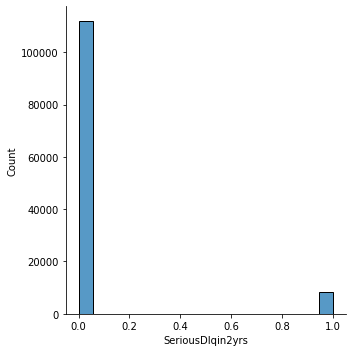

In [32]:
#check target distribution
df_target_nunique = df_cs_train.groupby(['SeriousDlqin2yrs']).size()
print("Target count values: ", df_target_nunique)

plt.figure(1)
sns.displot(df_cs_train['SeriousDlqin2yrs'], kind="hist")


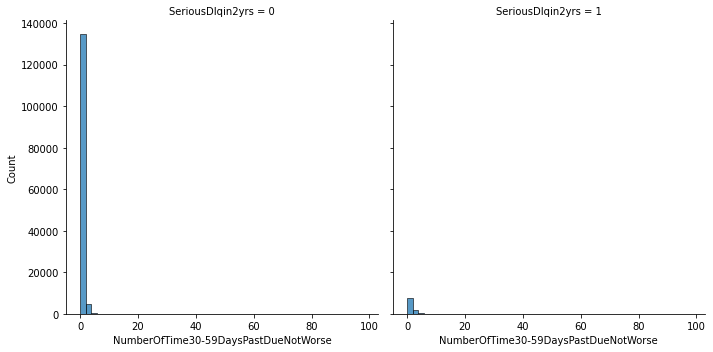

In [17]:
# plot hist feature data
# sns.displot(df_cs_train[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
#             , )
sns.displot(df_cs_train,x='NumberOfTime30-59DaysPastDueNotWorse',col='SeriousDlqin2yrs',bins=50)

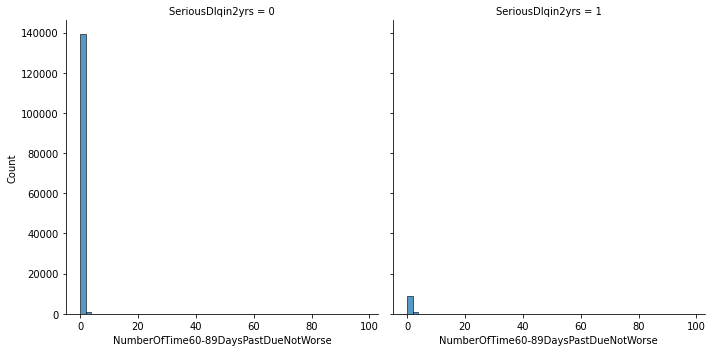

In [18]:
sns.displot(df_cs_train,x='NumberOfTime60-89DaysPastDueNotWorse',col='SeriousDlqin2yrs',bins=50)

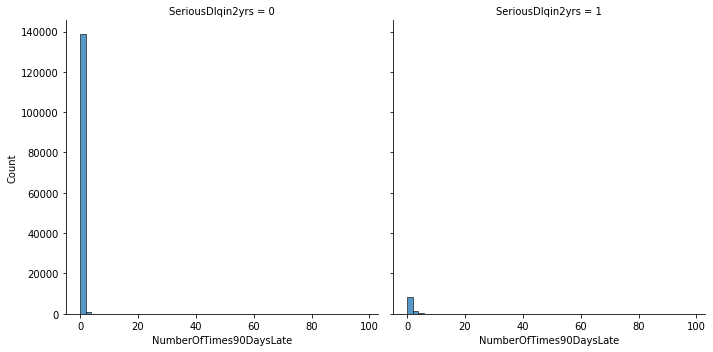

In [19]:
sns.displot(df_cs_train,x='NumberOfTimes90DaysLate',col='SeriousDlqin2yrs',bins=50)

In [20]:
df_cs_train.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [21]:
df_cs_train.DebtRatio.describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

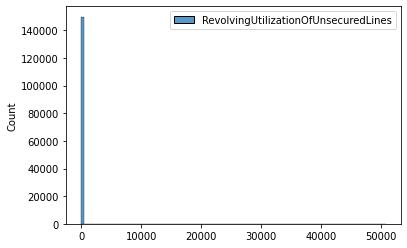

In [22]:
# plot hist feature data
sns.histplot(df_cs_train[['RevolvingUtilizationOfUnsecuredLines']],bins=100,)


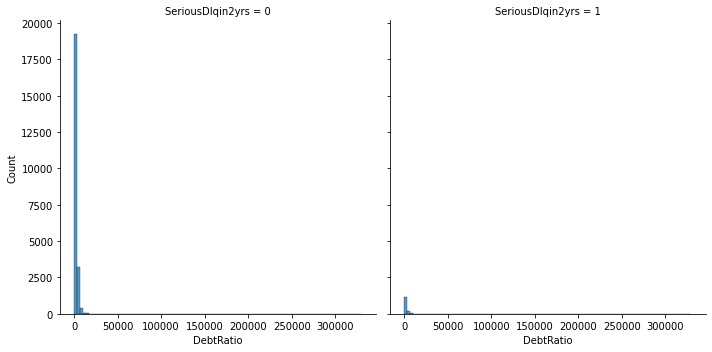

In [23]:
sns.displot(df_cs_train[df_cs_train['DebtRatio']>100],x='DebtRatio',col='SeriousDlqin2yrs',bins=100)

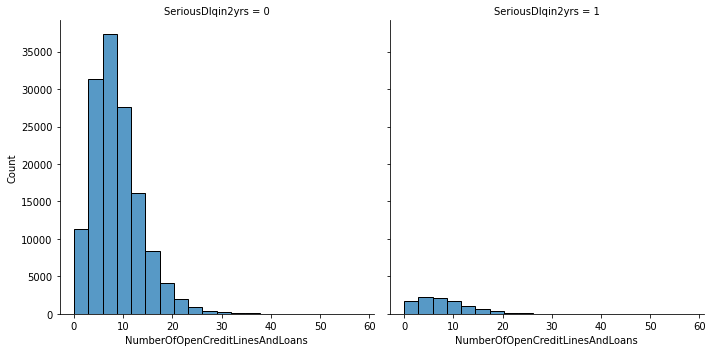

In [24]:
sns.displot(df_cs_train,x='NumberOfOpenCreditLinesAndLoans',col='SeriousDlqin2yrs',bins=20)

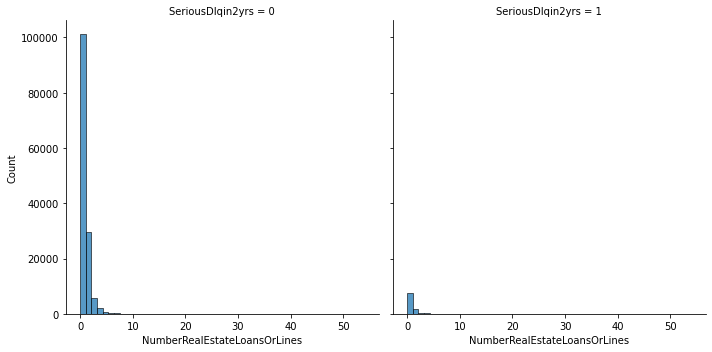

In [25]:
sns.displot(df_cs_train,x='NumberRealEstateLoansOrLines',col='SeriousDlqin2yrs',bins=50)

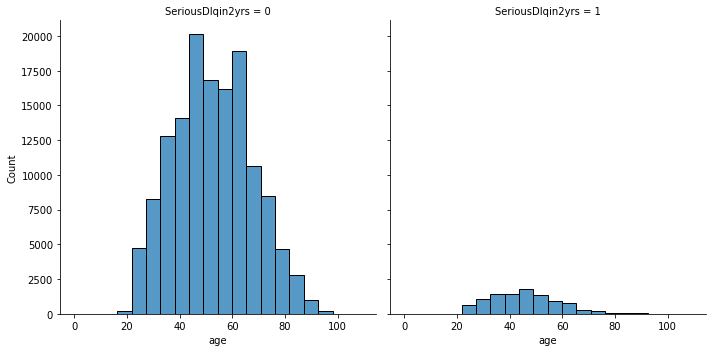

In [26]:
# plot hist feature data
# sns.displot(df_cs_train[['age']],bins=20)
sns.displot(df_cs_train,x='age',col='SeriousDlqin2yrs', bins=20)


In [27]:
df_cs_train.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

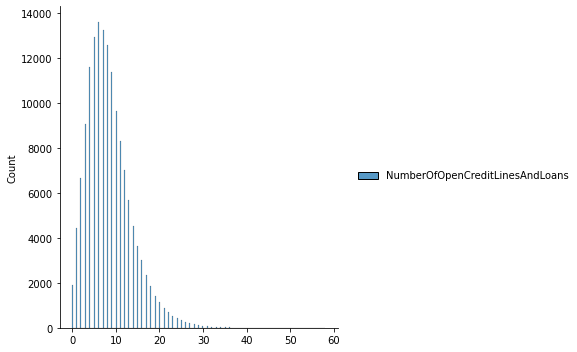

In [28]:
sns.displot(df_cs_train[['NumberOfOpenCreditLinesAndLoans']])


### Data Preprocessing, Feature Normalization
In this part I handle NaN values. I only keep non-NaN values for training as we have large enough data and doing imputation do not necessary return better outcome.
I also perform feature normalization.

In [80]:
# check & handle NaN values. 
df_cs_train = df_cs_train.dropna(axis=0) #drop null values data point

neg = df_target_nunique[0]
pos = df_target_nunique[1]
total = neg + pos
ratio_pos_neg = pos/neg # calculate ratio pos/neg samples


In [102]:
# Features Normalization
scaler = StandardScaler()
data_train_feat_norm = scaler.fit_transform(df_cs_train[col_feat])
data_test_feat_norm = scaler.transform(df_cs_test[col_feat])

data_train_feat_norm = np.clip(data_train_feat_norm, -5, 5)
data_test_feat_norm = np.clip(data_test_feat_norm, -5, 5)

y_train = df_cs_train[target].to_numpy()
# y_test is Nan, not provided

## Model Selection


#### 1. XGBoost
In first this first model, I perform grid search and cross validation to find the best model with XGBoost. 

In [37]:
# define function to perform grid search cross validation
def grid_search_cv(X_train_data, X_test_data, y_train_data, 
                       model, param_grid, cv=3, scoring_fit='roc_auc', do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [108]:
# set hyperparameters. The combination of hyperparameters can be extended. For the sake of time, I keep a few to speed up. 
params_grid = {
         'objective': ['binary:logistic']
         ,'n_estimators': [100,150,180]
         ,'eta': [0.05,0.3,0.5]
         ,'max_depth': [3,5,7]
         ,'subsample': [0.8,1] 
         ,'max_delta_step': [0,1,5]
         ,'lambda': [1,2]
         ,'scale_pos_weight': [1/ratio_pos_neg] # use scale_pos_weight to handle imbalance data pos/neg

         ,'nthread': [4]
         ,'gpu_id': [0] # use gpu
         ,'tree_method': ['gpu_hist']
         }

X_train = data_train_feat_norm
X_test = data_test_feat_norm

model_xgb = xgb.XGBClassifier()
fitted_xgb, pred = grid_search_cv(X_train, X_test, y_train, model_xgb, params_grid, cv=3)
print("model best params:", fitted_xgb.best_params_)
print("model best score: ", fitted_xgb.best_score_)

# write best parameters record into text file
with open(data_dir+'best_params.json', 'w') as fp:
    json.dump(fitted_xgb.best_params_, fp)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 22.9min finished


model best params: {'eta': 0.05, 'gpu_id': 0, 'lambda': 1, 'max_delta_step': 1, 'max_depth': 3, 'n_estimators': 150, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 13.391408400143591, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
model best score:  0.8554592718744608


In [109]:
# After finding the best model, we train the model with all available training data
# dtrain = xgb.DMatrix(X_train, label=y_train ) # convert to DMatrix type
# dtest = xgb.DMatrix(X_test, label=df_cs_test[target].to_numpy() )
# dtest = xgb.DMatrix(X_test )
# evallist = [(dtrain,'train')]

param = fitted_xgb.best_params_ #use best params from cv
param['eval_metric'] = 'auc'
clf = xgb.XGBClassifier(**param)
clf.fit(X_train, y_train, eval_metric='auc', verbose=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05,
              eval_metric='auc', gamma=0, gpu_id=0, lambda=1, learning_rate=0.1,
              max_delta_step=1, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=150, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=13.391408400143591, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

##### Predict Test Set

In [126]:
# run prediction on test set
y_pred_train = clf.predict_proba(X_train)[:,1] # take prediction probability of "1"

y_pred = clf.predict_proba(X_test)[:,1] # take prediction probability of "1"
df_pred_test = pd.Series.to_frame(df_cs_test['Unnamed: 0'])
df_pred_test = df_pred_test.rename(columns={"Unnamed: 0":"Id"})
df_pred_test["Probability"] = y_pred
df_pred_test.head()
# write prediction to csv file
df_pred_test.to_csv(data_dir+'cs_pred_xgb.csv', index=False)


##### Feature Importance Visualization
We plot feature importance from the learn classifier. It turns out that f0, f2 are the most important while f6 is the least.

['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']


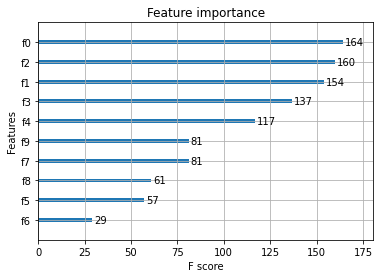

In [142]:
# vis feature importance
print(col_feat) # print coded sequence of features: f0, f1, ...
xgb.plot_importance(clf)


### Neural Network
In this part, I attempt to design a neural network to achieve better performance than XGBoost model. The first attempt has not been fruitful to pass the performance of XGBoost. Due to time, I have only did quick optimization (change network size, depth, and a few hyperparameters search). I didn't implement further optimization, e.g. automl. However, this should be a good demonstration of how to use neural network to make structured data prediction.


In [117]:
# Use neural network
# define the keras model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, input_dim=10, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# class weight to handle imbalance data
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.AUC(from_logits=True)],

              )


Weight for class 0: 0.54
Weight for class 1: 7.20


In [134]:
n_epoch = 25
history = model.fit(X_train, y_train,
          epochs= n_epoch, 
          batch_size= 512, 
          validation_split=0.1,
          shuffle = True,
          class_weight=class_weight # to handle imbalance class 
          )


Epoch 1/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5108 - auc_15: 0.8242 - val_loss: 0.5191 - val_auc_15: 0.8347
Epoch 2/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5106 - auc_15: 0.8241 - val_loss: 0.4991 - val_auc_15: 0.8342
Epoch 3/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5102 - auc_15: 0.8249 - val_loss: 0.4820 - val_auc_15: 0.8324
Epoch 4/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5100 - auc_15: 0.8246 - val_loss: 0.4858 - val_auc_15: 0.8329
Epoch 5/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5099 - auc_15: 0.8248 - val_loss: 0.4720 - val_auc_15: 0.8325
Epoch 6/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5097 - auc_15: 0.8249 - val_loss: 0.5058 - val_auc_15: 0.8348
Epoch 7/25
212/212 [==============================] - 1s 3ms/step - loss: 0.5095 - auc_15: 0.8250 - val_loss: 0.4963 - val_auc_15: 0.8316
Epoch 8/25
212/212 [==============

In [119]:
# make prediction on test set
y_pred_nn = model.predict(X_test, batch_size=256, verbose=1)
df_pred_test_nn = pd.Series.to_frame(df_cs_test['Unnamed: 0'])
df_pred_test_nn = df_pred_test_nn.rename(columns={"Unnamed: 0":"Id"})
df_pred_test_nn["Probability"] = y_pred_nn
df_pred_test_nn.head()
# write prediction to csv file
df_pred_test_nn.to_csv(data_dir+'cs_pred_nn.csv', index=False)


397/397 [==============================] - 0s 947us/step
